In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import copy
import pickle

In [2]:
# Read in the sample of complaints data
complaints_data = pd.read_csv('complaints_sample.csv')

## Check it out
complaints_data.head(5)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
0,2020-05-29,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,SHOWING A LATE ON MORTGAGE FCRA VIOLATIONS IF ...,NaN,"EQUIFAX, INC.",TX,750XX,NaN,Consent provided,Web,05/29/20,Closed with explanation,Yes,NaN,3673850
1,2020-04-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,My bank called me and told me there was an unk...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,AR,XXXXX,NaN,Consent provided,Web,04/08/20,Closed with explanation,Yes,NaN,3597513
2,2019-10-24,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,THE ACCOUNTS LISTED DOES NOT RELATE TO ANY TRA...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,33168,NaN,Consent provided,Web,10/24/19,Closed with non-monetary relief,Yes,NaN,3417138
3,2020-08-27,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,On XX/XX/2020. Contract Caller Inc added a der...,Company has responded to the consumer and the ...,CONTRACT CALLERS INC,WI,53216,NaN,Consent provided,Web,08/27/20,Closed with explanation,Yes,NaN,3817859
4,2020-09-04,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,TRANSUNIONThese 3 accounts are not mine. They ...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,116XX,NaN,Consent provided,Web,09/04/20,Closed with explanation,Yes,NaN,3831437


In [3]:
complaints_data.isnull().sum()

date_received                      0
product                            0
sub_product                        0
issue                              0
sub_issue                          0
consumer_complaint_narrative       0
company_public_response         1931
company                            0
state                              1
zip_code                           0
tags                            4504
consumer_consent_provided          0
submitted_via                      0
date_sent_to_company               0
company_response_to_consumer       0
timely_response                    0
consumer_disputed               5000
complaint_id                       0
dtype: int64

In [4]:
# Grabbing just the narrative text data in a separate object
complaints = complaints_data['consumer_complaint_narrative']

## Check it out
complaints.head(10)

0    SHOWING A LATE ON MORTGAGE FCRA VIOLATIONS IF ...
1    My bank called me and told me there was an unk...
2    THE ACCOUNTS LISTED DOES NOT RELATE TO ANY TRA...
3    On XX/XX/2020. Contract Caller Inc added a der...
4    TRANSUNIONThese 3 accounts are not mine. They ...
5    HAVE CONTACTED CREDIT BUREAUS ON NUMEROUS OCCA...
6    i have never file for bankruptcy me and my fat...
7    To : Whom It May concern : I am writing to dis...
8    This is the first time I have ever encountered...
9    i notice some negative items on my credit that...
Name: consumer_complaint_narrative, dtype: object

In [5]:
# Adding a few problematic words to the default stop words list before pre-processing
stop_words_adjusted = text.ENGLISH_STOP_WORDS.union(['xx','xxxx','xxxxxxxx','00'])

stop_words_adjusted = list(stop_words_adjusted)

In [6]:
## Creating empty object to store results
min_doc_frequencies = []

## Looping through values of min doc frequency of 1-20 and appending the resulting number of features for each
for i in range(1, 21):
    
    ## Implementing the tf-idf vectorizer with min_df of i
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_adjusted, min_df=i)
    
    ## Creating the dtm
    dtm = tfidf_vectorizer.fit_transform(complaints)
    
    ## Finding and appending the number of features for that min_df using get_feature_names_out()
    min_doc_frequencies.append([i, len(tfidf_vectorizer.get_feature_names_out())])
    
## Check it out
min_doc_frequencies


[[1, 8721],
 [2, 5282],
 [3, 4162],
 [4, 3520],
 [5, 3134],
 [6, 2867],
 [7, 2650],
 [8, 2500],
 [9, 2363],
 [10, 2242],
 [11, 2143],
 [12, 2055],
 [13, 1984],
 [14, 1901],
 [15, 1829],
 [16, 1769],
 [17, 1719],
 [18, 1660],
 [19, 1611],
 [20, 1545]]

In [7]:
# Storing results in dataframe
min_freqs_df = pd.DataFrame(min_doc_frequencies,columns=['Minimum_Document_Frequency','Number_of_Features'])
min_freqs_df.head()

,Minimum_Document_Frequency,Number_of_Features
0,1,8721
1,2,5282
2,3,4162
3,4,3520
4,5,3134


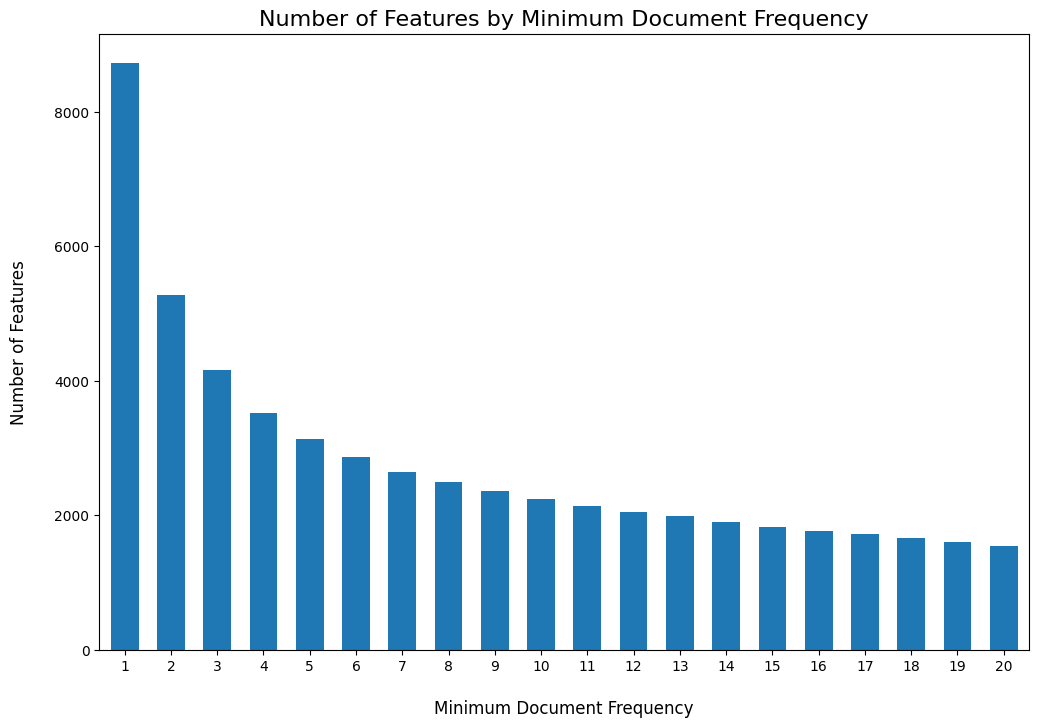

In [8]:
## Plotting the min document frequency counts
min_freqs_df.plot(x = 'Minimum_Document_Frequency', 
                  y = 'Number_of_Features', 
                  kind = 'bar',
                  figsize=(12,8),
                  legend = False,
                  width = 0.6)

plt.xlabel('\nMinimum Document Frequency',fontsize=12)
plt.ylabel('Number of Features\n',fontsize=12)
plt.title('Number of Features by Minimum Document Frequency',fontsize=16)
plt.xticks(rotation=0)

# Save to png
plt.savefig("min_doc_frequency_validation.png",facecolor='white', dpi=300)

plt.show()

In [9]:
# Vectorizing with min doc frequency of 4 and custom stop-words; applying TFIDF transformation
tfidf_vectorizer = TfidfVectorizer(stop_words = stop_words_adjusted, min_df = 4)
complaints_dtm = tfidf_vectorizer.fit_transform(complaints)
complaints_dtm.shape

(5000, 3520)

In [10]:
# Converting the dtm object to a dataframe
complaints_dtm_df = pd.DataFrame(complaints_dtm.toarray())

# Mapping column names to actual words
complaints_dtm_df.columns = tfidf_vectorizer.get_feature_names_out()

# Check it out
complaints_dtm_df.head(10)

,000,10,100,1000,10000,1001,1022,103,109,1099,...,xxxxxxxxxxxxxx,year,years,yes,yesterday,york,youll,young,yrs,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.145112,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#### Looking at most important features

## Summing up total tf-idf weights by term
term_weights = pd.DataFrame(complaints_dtm_df.sum(axis = 0))

## Resetting index so the term is in its own column
term_weights = term_weights.reset_index()

## Changing column headers
term_weights.columns = ['term','sum_weights']

## Store the top features
top_features = term_weights.sort_values('sum_weights', ascending = False)

## Check it out
top_features.head(10)

,term,sum_weights
1010,credit,405.608862
352,accounts,330.491091
348,account,302.688820
2755,report,301.831220
1790,information,235.335632
2759,reporting,200.343138
1725,identity,157.727563
1539,fraudulent,153.755294
2733,remove,152.552637
3193,theft,145.300075


In [13]:
#### Implementing CountVectorizer with all of the same preprocessing, just so I can get raw counts of appearances by term

## Vectorizing with min doc frequency of 4 and custom stop-words
count_vectorizer = CountVectorizer(stop_words = stop_words_adjusted, min_df = 4)
complaints_dtm_count = count_vectorizer.fit_transform(complaints)
complaints_dtm_count.shape

(5000, 3520)

In [14]:
## Converting the dtm object to a dataframe
complaints_dtm_count_df = pd.DataFrame(complaints_dtm_count.toarray())

## Mapping column names to actual words
complaints_dtm_count_df.columns = count_vectorizer.get_feature_names_out()

## Check it out
complaints_dtm_count_df.head(10)

,000,10,100,1000,10000,1001,1022,103,109,1099,...,xxxxxxxxxxxxxx,year,years,yes,yesterday,york,youll,young,yrs,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#### Summary stats for number of tokens per document

## Summing up total counts by document
term_counts = pd.DataFrame(complaints_dtm_count_df.sum(axis = 1))

## Changing column headers
term_counts.columns = ['total_tokens']

## Getting summary stats and storing in df
summary_tokens = pd.DataFrame(term_counts['total_tokens'].describe())

## Checking it out
summary_tokens

,total_tokens
count,5000.000000
mean,60.850800
std,109.735045
min,0.000000
25%,18.000000
50%,33.000000
75%,58.000000
max,1308.000000


In [19]:
## Hard-coding the SSE's and Silhouettes if the above loop is taking too long
k_values = range(2,11)
sse_hard_coded = [4666.036696944787, 4606.788935953148, 4552.373314302334, 4511.8394230777785, 4464.512349878195, 4401.428792045066, 4352.9533289170995, 4326.322318912044, 4284.07952302471]
silhouette_hard_coded = [np.float64(0.01579279739702201), np.float64(0.016968625127055884), np.float64(0.019162506023049315), np.float64(0.01869204469743189), np.float64(0.02235372881063379), np.float64(0.029761289235149577), np.float64(0.03293983383270099), np.float64(0.035016758017330576), np.float64(0.03903735103464108)]

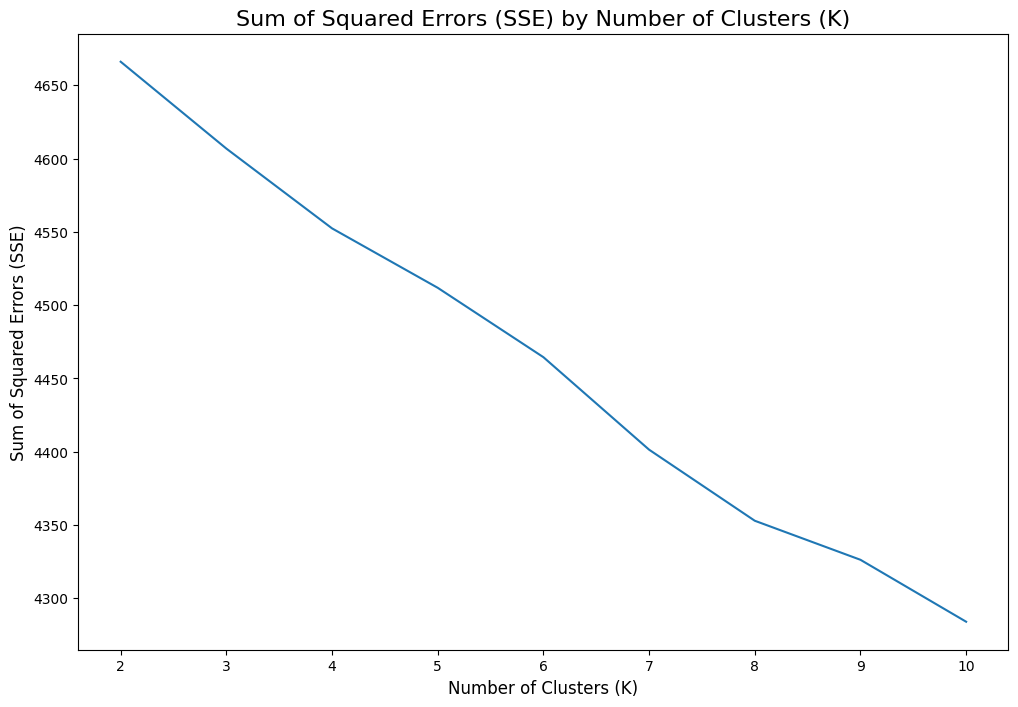

In [20]:
## SSE Validation Curve
plt.figure(figsize=(12,8))
plt.plot(k_values, sse_hard_coded)
plt.xlabel('Number of Clusters (K)',fontsize=12)
plt.ylabel('Sum of Squared Errors (SSE)',fontsize=12)
plt.title('Sum of Squared Errors (SSE) by Number of Clusters (K)',fontsize=16)


## Save to png
#plt.savefig("Tables_Graphics/sse_validation.png",facecolor='white', dpi=300)

plt.show()

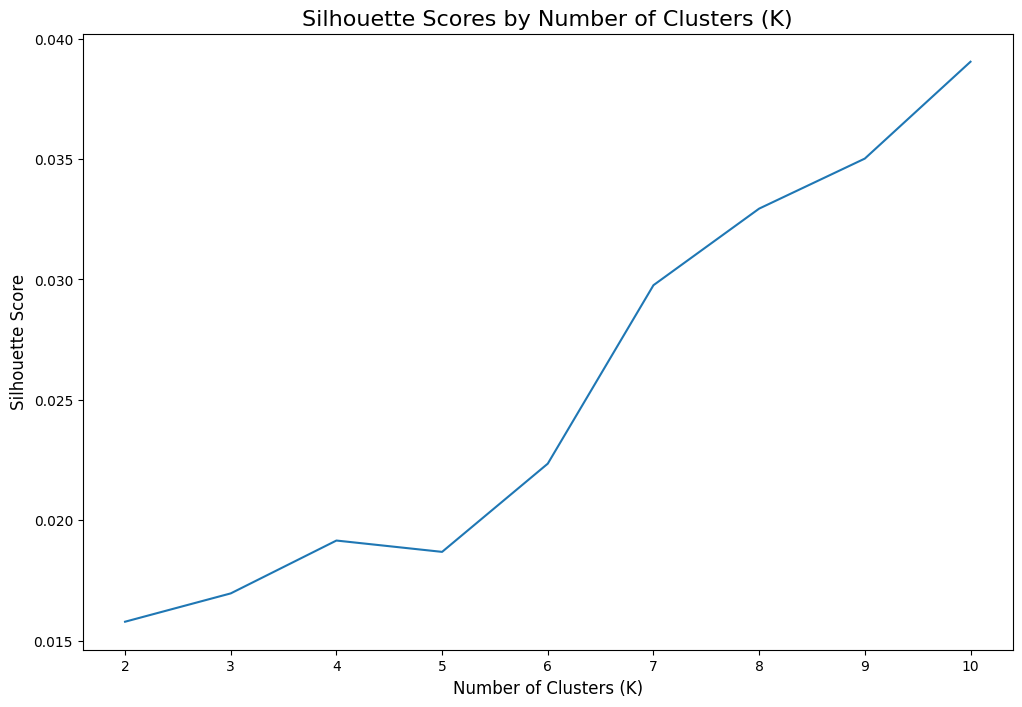

In [21]:
## Silhouette Validation Curve
plt.figure(figsize=(12,8))
plt.plot(k_values, silhouette_hard_coded)
plt.xlabel('Number of Clusters (K)',fontsize=12)
plt.ylabel('Silhouette Score',fontsize=12)
plt.title('Silhouette Scores by Number of Clusters (K)',fontsize=16)

## Save to png
#plt.savefig("Tables_Graphics/silhouette_validation.png",facecolor='white', dpi=300)

plt.show()

In [22]:
## Implementing KMeans with K = 7
k_means = KMeans(random_state = 123, n_clusters = 5)

## Making clustering predictions
k_means_labels = k_means.fit_predict(complaints_dtm)

In [23]:
## Organizing text and labels into dataframe
k_means_df = pd.DataFrame({'complaint':complaints,'cluster':k_means_labels})

## Check it out
k_means_df.head(40)

,complaint,cluster
0,SHOWING A LATE ON MORTGAGE FCRA VIOLATIONS IF ...,1
1,My bank called me and told me there was an unk...,1
2,THE ACCOUNTS LISTED DOES NOT RELATE TO ANY TRA...,0
3,On XX/XX/2020. Contract Caller Inc added a der...,1
4,TRANSUNIONThese 3 accounts are not mine. They ...,0
5,HAVE CONTACTED CREDIT BUREAUS ON NUMEROUS OCCA...,4
6,i have never file for bankruptcy me and my fat...,1
7,To : Whom It May concern : I am writing to dis...,2
8,This is the first time I have ever encountered...,0
9,i notice some negative items on my credit that...,1


In [24]:
# Checking out number of documents per cluster
k_means_df.groupby(by='cluster').agg('count')

,complaint
cluster,
0,1088
1,2182
2,457
3,42
4,1231


In [25]:
# Combining the k-means results with the dtm df
k_means_dtm_df = pd.concat([k_means_df, complaints_dtm_df], axis=1)

## Check it out
k_means_dtm_df.head(10)

,complaint,cluster,000,10,100,1000,10000,1001,1022,103,...,xxxxxxxxxxxxxx,year,years,yes,yesterday,york,youll,young,yrs,zero
0,SHOWING A LATE ON MORTGAGE FCRA VIOLATIONS IF ...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,My bank called me and told me there was an unk...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.145112,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,THE ACCOUNTS LISTED DOES NOT RELATE TO ANY TRA...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,On XX/XX/2020. Contract Caller Inc added a der...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRANSUNIONThese 3 accounts are not mine. They ...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,HAVE CONTACTED CREDIT BUREAUS ON NUMEROUS OCCA...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,i have never file for bankruptcy me and my fat...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,To : Whom It May concern : I am writing to dis...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,This is the first time I have ever encountered...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,i notice some negative items on my credit that...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Summing up total tf-idf weights by cluster and term
cluster_term_weights = pd.DataFrame(k_means_dtm_df.groupby(['cluster']).sum()).transpose()

## Resetting index so the term is in its own column
cluster_term_weights = cluster_term_weights.reset_index()

## Check it out
cluster_term_weights.head(10)

cluster,index,0,1,2,3,4
0,complaint,THE ACCOUNTS LISTED DOES NOT RELATE TO ANY TRA...,SHOWING A LATE ON MORTGAGE FCRA VIOLATIONS IF ...,To : Whom It May concern : I am writing to dis...,Accounts added and/or created unbeknownst to m...,HAVE CONTACTED CREDIT BUREAUS ON NUMEROUS OCCA...
1,000,0.277111,1.293607,0.0,0.0,0.18967
2,10,3.545455,6.177711,0.752606,0.0,2.483492
3,100,1.747243,5.58981,0.346233,0.0,4.933987
4,1000,7.085196,4.975221,2.520962,0.0,0.699286
5,10000,0.964072,1.551267,1.401887,0.0,0.674736
6,1001,0.0,0.0,0.31589,0.0,0.0
7,1022,0.0,0.0,0.31589,0.0,0.0
8,103,0.0,0.395286,0.15492,0.0,0.136994
9,109,0.0,0.504806,0.0,0.0,0.030986


In [27]:
## Writing cluster term weights to csv
#cluster_term_weights.to_csv('Tables_Graphics/k_means_cluster_term_weights.csv')

# Number of top words to display
top_n_words = 20

# Getting the feature names (words)
terms = tfidf_vectorizer.get_feature_names_out()

# Looping through each cluster to get the top words
for i in range(5):  # 7 because you set n_clusters = 7
    print(f"\nCluster {i}:")
    
    # Getting the cluster center
    centroid = k_means.cluster_centers_[i]
    
    # Sorting the words by importance in the centroid
    top_indices = centroid.argsort()[-top_n_words:][::-1]
    
    # Displaying the top words for this cluster
    top_words = [terms[ind] for ind in top_indices]
    print(top_words)

# Focus on fraudulent activities: Words like fraudulent, unknown, identity, and belong indicate that these complaints likely revolve around fraud or identity theft issues, where accounts or reports contain items that do not belong to the consumer.
# Cluster 1:

# General credit report issues: This cluster emphasizes words like credit, report, information, items, reporting, and debt. These complaints likely deal with incorrect or incomplete information on credit reports, account-related problems, or disputes with debt-related companies.
# Cluster 2:

# Identity theft and consumer protection: This cluster focuses on identity theft and victim scenarios, including words like block, opened, acct (account), and consumer. It points to cases where people are dealing with the aftermath of identity theft, often involving unauthorized accounts being opened in their name.
# Cluster 3:

# Legal and compliance issues: Words such as claim, compliance, claims, plaintiff, and requisite suggest that these complaints are more legal in nature, possibly involving compliance disputes with debt collection agencies or legal action against fraudulent claims.
# Cluster 4:

# Late payments and inaccurate reports: This cluster appears to focus on late payments, inaccurate information, and issues with credit reporting. Complaints in this group may be related to consumers contesting late payments or inaccuracies on their credit reports affecting their credit scores.



Cluster 0:
['accounts', 'credit', 'report', 'remove', 'fraudulent', 'items', 'pulled', 'unknown', 'identity', 'belong', 'open', 'theft', 'inquiries', 'file', 'opened', 'listed', 'things', 'couple', 'did', 'derogatory']

Cluster 1:
['credit', 'report', 'information', 'items', 'reporting', 'account', 'accounts', 'debt', 'company', 'loan', 'equifax', 'remove', 'sent', 'experian', 'bankruptcy', 'inquiry', 'address', 'removed', 'inquiries', 'card']

Cluster 2:
['theft', 'identity', 'victim', 'information', 'consumer', 'section', 'acct', 'block', 'opened', 'account', '12', 'credit', 'fraudulent', 'charge', 'act', 'fair', 'request', 'pursuant', '226', 'accounts']

Cluster 3:
['claim', 'compliance', 'claims', 'compliant', 'collection', 'reporting', 'plaintiff', 'alleged', 'debt', 'requisite', 'document', 'mandatory', 'practices', 'physically', 'verifiable', 'accusers', 'regulatory', 'plaintiffs', 'standards', 'relationship']

Cluster 4:
['account', 'credit', 'reporting', 'late', 'information'

In [33]:
cluster_names = {
    0: 'Fraudulent Activity Reports',
    1: 'Credit Report Disputes',
    2: 'Identity Theft Claims',
    3: 'Debt Collection Compliance',
    4: 'Inaccurate Credit Reporting'
}